In [14]:

import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style="seaborn"
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Load DataFrames from CSV
X_train_pca_df = pd.read_csv("X_train_pca.csv")
X_val_pca_df = pd.read_csv("X_val.csv")
X_test_pca_df = pd.read_csv("X_test.csv")
Y_train = pd.read_csv("Y_train.csv")
Y_val = pd.read_csv("Y_val.csv")
Y_test = pd.read_csv("Y_test.csv")

In [16]:
import pandas as pd
import numpy as np
import math


class DecisionTree():
    def __init__(self, x, y, min_leaf):
        self.x = x
        self.y = y
        self.min_leaf = min_leaf
        self.row_count = x.shape[0]
        self.idxs = np.array(range(self.row_count))
        self.category_count = x.shape[1]
        self.val = np.mean(y.values[self.idxs])
        self.score = float('inf')

        self.left_decision_tree = None
        self.right_decision_tree = None
        self.splitting_category_id = None
        self.split_val = None

        self.find_split_category()

    def find_split_category(self):
        for i in range(self.category_count):
            self.check_category_for_split(i)

        if self.is_leaf:
            return

        x = self.split_col

        lhs = np.nonzero(x <= self.split_val)[0]
        rhs = np.nonzero(x > self.split_val)[0]

        self.left_decision_tree = DecisionTree(
            self.x.iloc[lhs], self.y.iloc[lhs], self.min_leaf)
        self.right_decision_tree = DecisionTree(
            self.x.iloc[rhs], self.y.iloc[rhs], self.min_leaf)

    def check_category_for_split(self, category_id):
        x = self.x.values[self.idxs, category_id]
        y = self.y.values[self.idxs]

        sorted_idx = np.argsort(x)
        sorted_x = x[sorted_idx]
        sorted_y = y[sorted_idx]

        # Standard deviation criterion specific
        # TODO Refactor code and create other criterion

        rhs_count = self.row_count
        rhs_sum = sorted_y.sum()
        rhs_square_sum = (sorted_y ** 2).sum()

        lhs_count = 0
        lhs_sum = 0.0
        lhs_square_sum = 0.0

        for i in range(0, self.row_count - self.min_leaf):
            x_i = sorted_x[i]
            y_i = sorted_y[i]

            lhs_count += 1
            rhs_count -= 1

            lhs_sum += y_i
            rhs_sum -= y_i

            lhs_square_sum += y_i ** 2
            rhs_square_sum -= y_i ** 2

            if i < self.min_leaf - 1 or x_i == sorted_x[i + 1]:
                continue

            lhs_std = self.std_deviation_score(
                lhs_count, lhs_sum, lhs_square_sum)
            rhs_std = self.std_deviation_score(
                rhs_count, rhs_sum, rhs_square_sum)
            curr_score = lhs_std * lhs_count + rhs_std * rhs_count

            if curr_score < self.score:
                self.splitting_category_id = category_id
                self.score = curr_score
                self.split_val = x_i

    def std_deviation_score(self, count, sum_val, square_sum):
        return math.sqrt((square_sum / count) - (sum_val / count) ** 2)

    @property
    def split_name(self):
        return self.x.columns[self.splitting_category_id]

    @property
    def split_col(self):
        return self.x.values[self.idxs, self.splitting_category_id]

    @property
    def is_leaf(self):
        return self.score == float('inf')

    def predict(self, x):
        rows = [self.predict_row(x_i[1]) for x_i in x.iterrows()]
        return np.array(rows)

    def predict_row(self, x_i):
        if self.is_leaf:
            return self.val

        if x_i[self.splitting_category_id] <= self.split_val:
            return self.left_decision_tree.predict_row(x_i)
        else:
            return self.right_decision_tree.predict_row(x_i)

In [30]:
# Initialize and fit the decision tree model
tree_model = DecisionTree(max_depth=3, threshold_entropy=0.05)
tree_model.fit(X_train_pca_df.values, Y_train.values)


Fitting decision tree...
Building tree at depth 0...
Building tree at depth 1...
Reached leaf node at depth 1. Class: 0
Building tree at depth 1...
Building tree at depth 2...
Reached leaf node at depth 2. Class: 1
Building tree at depth 2...
Building tree at depth 3...
Reached leaf node at depth 3. Class: 0
Building tree at depth 3...
Reached maximum depth or no more features to split at depth 3. Choosing majority class.
Split at depth 2: Feature 0 <= -8.332178573130934
Left subtree: 0
Right subtree: 0
Split at depth 1: Feature 0 <= -8.497109280248525
Left subtree: 1
Right subtree: {'feature_index': 0, 'threshold': -8.332178573130934, 'left_subtree': 0, 'right_subtree': 0}
Split at depth 0: Feature 0 <= -8.610437756226176
Left subtree: 0
Right subtree: {'feature_index': 0, 'threshold': -8.497109280248525, 'left_subtree': 1, 'right_subtree': {'feature_index': 0, 'threshold': -8.332178573130934, 'left_subtree': 0, 'right_subtree': 0}}
Tree fitting completed.


In [31]:
# Make predictions
predictions = tree_model.predict(X_test_pca_df.values)

# Evaluate the model
accuracy = (predictions == Y_test.values.flatten()).mean()
print("Accuracy:", accuracy)

Accuracy: 0.7716103942018738


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the ranges for max_depth and threshold_entropy
max_depth_range = np.arange(1, 6)
threshold_range = np.concatenate((np.arange(0.01, 0.1, 0.01), np.arange(0.1, 0.5, 0.1)))

# Initialize lists to store results
depth_values = []
threshold_values = []
accuracy_values = []

# Loop through different combinations of max_depth and threshold_entropy
for max_depth in max_depth_range:
    for threshold_entropy in threshold_range:
        # Initialize and fit the decision tree model
        tree_model = DecisionTree(max_depth=max_depth, threshold_entropy=threshold_entropy)
        tree_model.fit(X_train_pca_df.values, Y_train.values)
        
        # Make predictions
        predictions = tree_model.predict(X_test_pca_df.values)
        
        # Evaluate the model
        accuracy = (predictions == Y_test.values.flatten()).mean()
        
        # Store the results
        depth_values.append(max_depth)
        threshold_values.append(threshold_entropy)
        accuracy_values.append(accuracy)

# Convert lists to arrays for plotting
depth_values = np.array(depth_values)
threshold_values = np.array(threshold_values)
accuracy_values = np.array(accuracy_values)

# Plot the graph
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(depth_values, threshold_values, accuracy_values, c='b', marker='o')

ax.set_xlabel('Max Depth')
ax.set_ylabel('Threshold Entropy')
ax.set_zlabel('Accuracy')

plt.title('Accuracy vs Max Depth and Threshold Entropy')
plt.show()


Fitting decision tree...
Building tree at depth 0...
Building tree at depth 1...
Reached leaf node at depth 1. Class: 0
Building tree at depth 1...
Reached maximum depth or no more features to split at depth 1. Choosing majority class.
Split at depth 0: Feature 0 <= -8.610437756226176
Left subtree: 0
Right subtree: 0
Tree fitting completed.
Fitting decision tree...
Building tree at depth 0...
Building tree at depth 1...
Reached leaf node at depth 1. Class: 0
Building tree at depth 1...
Reached maximum depth or no more features to split at depth 1. Choosing majority class.
Split at depth 0: Feature 0 <= -8.610437756226176
Left subtree: 0
Right subtree: 0
Tree fitting completed.
Fitting decision tree...
Building tree at depth 0...
Building tree at depth 1...
Reached leaf node at depth 1. Class: 0
Building tree at depth 1...
Reached maximum depth or no more features to split at depth 1. Choosing majority class.
Split at depth 0: Feature 0 <= -8.610437756226176
Left subtree: 0
Right subtre

In [3]:
#USING INBUILT LIBRARY

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Define the maximum depth of the decision tree
max_depth = 5

# Define the minimum entropy decrease threshold for splitting
min_impurity_decrease = 0.0  # Adjust this threshold as needed

# Initialize the decision tree classifier with entropy criterion
clf = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, min_impurity_decrease=min_impurity_decrease, random_state=42)

# Train the decision tree classifier
clf.fit(X_train_pca_df, Y_train)

# Predict on the testing set
y_pred = clf.predict(X_val_pca_df)

# Calculate accuracy
accuracy = accuracy_score(Y_val, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8566882734236889


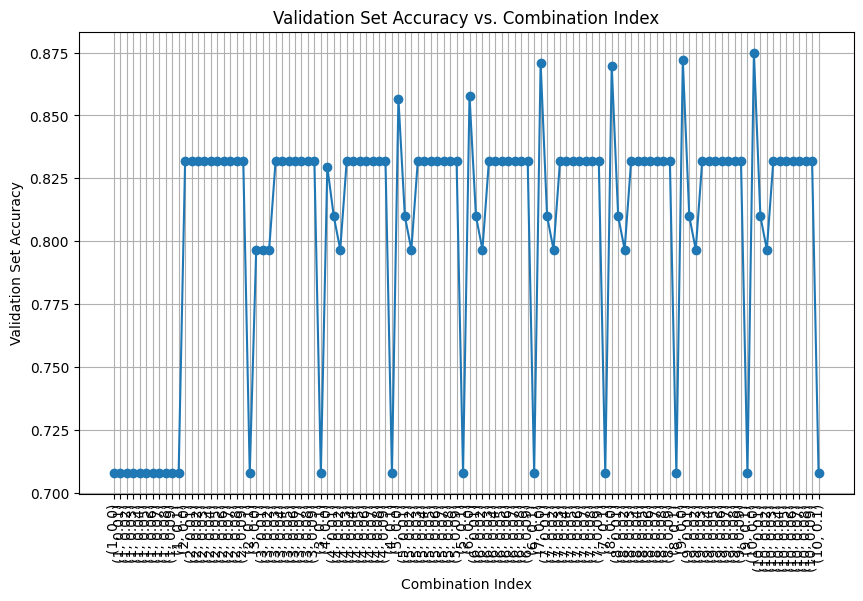

Maximum Validation Set Accuracy: 0.8749558043606365
Best Depth: 10
Best Threshold: 0.0


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Define the range of depths and thresholds to try
depths = range(1, 11)  # Try depths from 1 to 10
thresholds = np.linspace(0, 0.1, 11)  # Try thresholds from 0 to 0.1 in steps of 0.01

# Initialize variables to store the maximum accuracy and corresponding parameters
max_accuracy = 0
best_depth = 0
best_threshold = 0

# Initialize lists to store accuracies for plotting
accuracies = []

# Loop over different depths and thresholds
for depth in depths:
    for threshold in thresholds:
        # Initialize the decision tree classifier with entropy criterion
        clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth, min_impurity_decrease=threshold, random_state=42)

        # Train the decision tree classifier
        clf.fit(X_train_pca_df, Y_train)

        # Predict on the validation set
        y_pred_val = clf.predict(X_val_pca_df)

        # Calculate accuracy on the validation set
        accuracy = accuracy_score(Y_val, y_pred_val)
        accuracies.append(accuracy)

        # Check if this combination yields the maximum accuracy
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_depth = depth
            best_threshold = threshold

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(accuracies, marker='o')
plt.title('Validation Set Accuracy vs. Combination Index')
plt.xlabel('Combination Index')
plt.ylabel('Validation Set Accuracy')
plt.xticks(range(len(depths) * len(thresholds)), [(d, t) for d in depths for t in thresholds], rotation=90)
plt.grid(True)

# Save the figure
plt.savefig('validation_accuracy_plot.png')

plt.show()

print("Maximum Validation Set Accuracy:", max_accuracy)
print("Best Depth:", best_depth)
print("Best Threshold:", best_threshold)


In [10]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Initialize the decision tree classifier with the best depth and threshold
best_clf = DecisionTreeClassifier(criterion='entropy', max_depth=best_depth, min_impurity_decrease=best_threshold, random_state=42)

# Train the decision tree classifier on the entire training data
best_clf.fit(X_train_pca_df, Y_train)

# Predict on the test set
y_pred_test = best_clf.predict(X_test_pca_df)

# Calculate accuracy
accuracy = accuracy_score(Y_test, y_pred_test)

# Calculate F1 score
f1 = f1_score(Y_test, y_pred_test)

# Calculate AUC score
# Since DecisionTreeClassifier doesn't have a predict_proba method, we cannot directly calculate AUC.
# Instead, we can use the decision function (predicting class labels) to get a proxy for AUC.
# Note: AUC score may not be very meaningful for Decision Trees without probabilities.
# Predict probabilities for the positive class (class 1)
y_prob_test = best_clf.predict_proba(X_test_pca_df)[:, 1]

# Calculate AUC score
auc = roc_auc_score(Y_test, y_prob_test)



print("Test Set Accuracy:", accuracy)
print("Test Set F1 Score:", f1)
print("Test Set AUC Score:", auc)


Test Set Accuracy: 0.8986566108885222
Test Set F1 Score: 0.8026617714547958
Test Set AUC Score: 0.9561291059318443


In [ ]:
# Test Set Accuracy: The accuracy of the model on the test set is approximately 89.87%. This means that around 89.87% of the instances in the test set were correctly classified by the model.
# Test Set F1 Score: The F1 score of the model on the test set is approximately 0.803. The F1 score is the harmonic mean of precision and recall. It provides a balance between precision and recall and is especially useful when dealing with imbalanced datasets. A higher F1 score indicates better performance.
# Test Set AUC Score: The AUC (Area Under the ROC Curve) score of the model on the test set is approximately 0.956. The ROC curve plots the true positive rate (sensitivity) against the false positive rate (1-specificity) for different threshold values. The AUC score represents the degree of separability between the classes. A higher AUC score (closer to 1) indicates better discrimination ability of the model.

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(Y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      6533
           1       0.73      0.90      0.80      1953

    accuracy                           0.90      8486
   macro avg       0.85      0.90      0.87      8486
weighted avg       0.91      0.90      0.90      8486



In [ ]:
# PLOT A ACCURACY VS DEPTH AND ACCURACY VY THRESHOLD_ENTROPY GRAPH

In [ ]:
#THEN PICK THE DEPTH AND THRESHOLD ENTROPY FOR WHICH  FOR WHICH MAXIMUM ACCURACY IS FOUND AND THEN PRINT THAT ACCURACY

In [ ]:
# tree_model = DecisionTree(max_depth=AS OBTAINED FROM GRAPH, threshold_entropy=AS OBTAINED FROM GRAPH)
# tree_model.fit(X_train_pca_df.values, Y_train.values)
# # 